In [1]:
MONK_TASK = 2
USER = "Nunzio"

In [2]:
import sys
import os
if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "/content/drive/Shareddrives/Project_ML_23/" + USER + "/machine-learning-project"
    sys.path.insert(0,BASE_PATH)
    sys.path.insert(0,BASE_PATH + "/src/utils")
    N_JOBS = 1
    !pip install optuna
    !pip install scikit-learn
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join(BASE_PATH, 'datasets', 'monk',f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'monk',  f'task-{MONK_TASK}', 'random_forest')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'monk', f'task-{MONK_TASK}')
else : 
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.train')
    TEST_DATA = os.path.join('..', '..', '..', 'datasets', 'monk', f'monks-{MONK_TASK}.test')
    IMAGES_FOLDER = os.path.join('..', '..', '..', 'images', 'monk', f'task-{MONK_TASK}', 'random_forest')
    MODEL_FOLDER = os.path.join('..', '..', '..', 'trained_models', 'monk', f'task-{MONK_TASK}')

In [3]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + "/src/utils")
else:
    sys.path.append(os.path.join('..','..', 'utils'))


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')


from utils import save_plot, set_random_state

set_random_state(42)

/Users/paolomollica/Projects/data-spell-projects/machine-learning-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 8))

df_train = pd.read_csv(TRAIN_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_test = pd.read_csv(TEST_DATA, header=None, usecols=columns_to_read, delimiter=' ')
df_train.head()

,1,2,3,4,5,6,7
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1


In [5]:
features = ['feature_' + str(i) for i in range(1, 7)]

# Rename columns
new_column_names = ['class'] + features

df_train.columns = new_column_names
df_test.columns = new_column_names

df_train.head()

,class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0,1,1,1,1,2,2
1,0,1,1,1,1,4,1
2,0,1,1,1,2,1,1
3,0,1,1,1,2,1,2
4,0,1,1,1,2,2,1


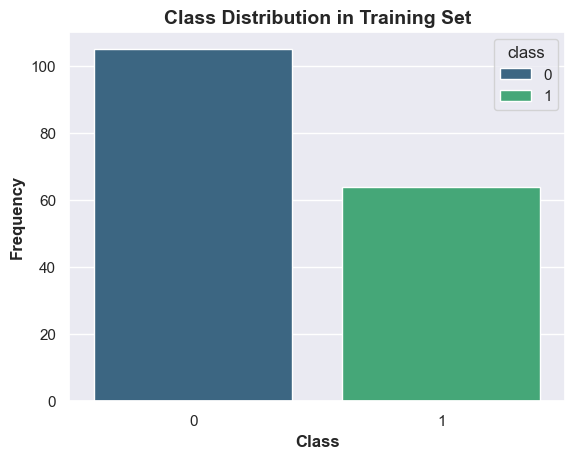

In [6]:
sns.countplot(x='class', data=df_train, hue='class', palette='viridis')

plt.title('Class Distribution in Training Set', fontweight='bold', fontsize=14)
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')

save_plot(plt, IMAGES_FOLDER, 'train_class_distribution')
plt.show()

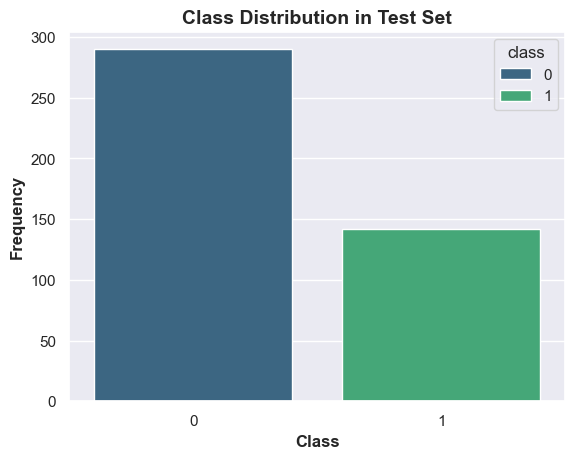

In [7]:
sns.countplot(x='class', data=df_test, hue='class', palette='viridis')

plt.title('Class Distribution in Test Set', fontweight='bold', fontsize=14)
plt.xlabel('Class', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')

save_plot(plt, IMAGES_FOLDER, 'test_class_distribution')
plt.show()

In [8]:
df_train_encoded = pd.get_dummies(df_train, columns=features)
df_test_encoded = pd.get_dummies(df_test, columns=features)

df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='inner', axis=1)

df_train_encoded.head()

,class,feature_1_1,feature_1_2,feature_1_3,feature_2_1,feature_2_2,feature_2_3,feature_3_1,feature_3_2,feature_4_1,feature_4_2,feature_4_3,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_6_1,feature_6_2
0,0,True,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,True
1,0,True,False,False,True,False,False,True,False,True,False,False,False,False,False,True,True,False
2,0,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,True,False
3,0,True,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True
4,0,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False


In [9]:
features = df_train_encoded.columns.difference(['class'])

X_train = df_train_encoded[features].to_numpy()
y_train = df_train_encoded['class'].to_numpy()

X_test = df_test_encoded[features].to_numpy()
y_test = df_test_encoded['class'].to_numpy()

# Create model

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    n_jobs=N_JOBS,
    verbose=2,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=20; total time=   0.1s
[CV] END bootst

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [20, 50, 100, 200]},
             scoring='accuracy', verbose=2)

In [12]:
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score

final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

print('Best parameters: ', grid_search.best_params_)
print('Best accuracy: ', grid_search.best_score_)
print('Test set accuracy: ', accuracy_score(y_test, y_pred))
print('Test set balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy:  0.6516934046345811
Test set accuracy:  0.8194444444444444
Test set balanced accuracy:  0.8259834871296745
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       290
           1       0.68      0.85      0.75       142

    accuracy                           0.82       432
   macro avg       0.80      0.83      0.81       432
weighted avg       0.84      0.82      0.82       432


# Learning curve

In [13]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

[learning_curve] Training set sizes: [ 13  44  74 105 135]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.6s finished


In [14]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

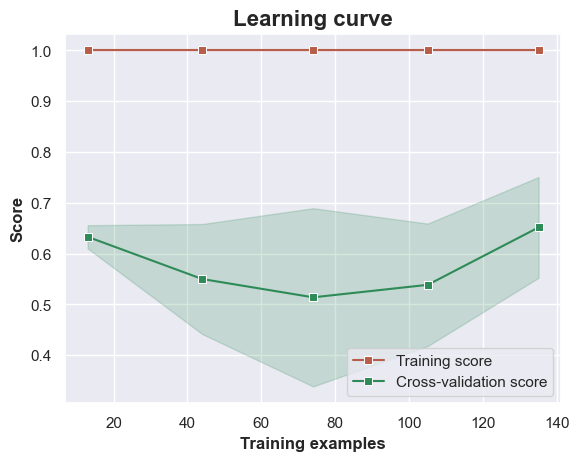

In [15]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=train_scores_mean, marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=validation_scores_mean, marker='s', color=color2, label='Cross-validation score')

plt.legend(loc='lower right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Save model

In [16]:
from joblib import dump

model_path = os.path.join(MODEL_FOLDER, 'random_forest_model.joblib')
dump(final_model, model_path, compress=3)

['../../../trained_models/monk/task-2/random_forest_model.joblib']